# Hot dog/Not Hot dog

In [1]:
# to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pycocotools.coco import COCO
from IPython.display import HTML

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Check if GPU is ready
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


## Reference Scene

In [4]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/vIci3C4JkL0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

## Data Prep

Here, we create a training and validation set of *hot dogs* and *not hot dogs* by copying the relevant images from the COCO dataset using the COCO Python API to work with the annotation files.

Note, here we do not have to worry about splitting the data into training and validation sets because COCO has already done that for us.

In [7]:
# Path variable pointing to coco dataset
PATH = Path('data/coco/')

In [8]:
# List files in PATH
list(PATH.iterdir())

[PosixPath('data/coco/.gitignore'),
 PosixPath('data/coco/train2017'),
 PosixPath('data/coco/val2017'),
 PosixPath('data/coco/annotations')]

In [ ]:
# Read the training and validation annotation files
coco_trn = COCO(PATH/'annotations/instances_train2017.json')
coco_val = COCO(PATH/'annotations/instances_val2017.json')

In [12]:
# Get IDs for all of the images
all_img_ids_trn = coco_trn.getImgIds()
all_img_ids_val = coco_val.getImgIds()

In [85]:
# Get the category ID for hot dog
hotdog_id = coco_trn.getCatIds(catNms=['hot dog'])

# Get the 
hd_img_ids_trn = coco_trn.getImgIds(catIds=hotdog_id)
hd_img_ids_val = coco_val.getImgIds(catIds=hotdog_id)

nhd_img_ids_trn = list(set(all_img_ids_trn).symmetric_difference(hd_img_ids_trn))
nhd_img_ids_val = list(set(all_img_ids_val).symmetric_difference(hd_img_ids_val))

In [86]:
hd_trn_ims = coco_trn.loadImgs(hd_img_ids_trn)
hd_val_ims = coco_val.loadImgs(hd_img_ids_val)

nhd_trn_ims = coco_trn.loadImgs(nhd_img_ids_trn)
nhd_val_ims = coco_val.loadImgs(nhd_img_ids_val)

In [87]:
len(hd_trn_ims), len(hd_val_ims)

(1222, 51)

In [89]:
def copy_coco_ims(coco_ob, im_obs, im_src, im_dst):
    PTH = PATH/im_dst
    if not PTH.exists(): PTH.mkdir()
    for im in tqdm(im_obs):
        fn = im['file_name']
        src = PATH/im_src/fn
        dst = PATH/im_dst/fn
        shutil.copyfile(src, dst)

In [36]:
!mkdir ../data/coco/hotdogs_train
!mkdir ../data/coco/hotdogs_valid

In [12]:
copy_coco_ims(coco_trn, hd_trn_ims, 'train2017', 'hotdogs_train/hotdog')
copy_coco_ims(coco_val, hd_val_ims, 'val2017', 'hotdogs_valid/hotdog')

copy_coco_ims(coco_trn, nhd_trn_ims[:(4*len(hd_trn_ims))], 'train2017', 'hotdogs_train/nothotdog')
copy_coco_ims(coco_val, nhd_val_ims[:(4*len(hd_val_ims))], 'val2017', 'hotdogs_valid/nothotdog')

100%|██████████| 204/204 [00:00<00:00, 468.83it/s]


## First look at pictures

In [93]:
list(PATH.iterdir())

[PosixPath('../data/coco/train_ml.csv'),
 PosixPath('../data/coco/ml_anns.csv'),
 PosixPath('../data/coco/tmp'),
 PosixPath('../data/coco/hotdogs_valid'),
 PosixPath('../data/coco/valid_ml.csv'),
 PosixPath('../data/coco/models'),
 PosixPath('../data/coco/person_mask_train'),
 PosixPath('../data/coco/person_mask_val'),
 PosixPath('../data/coco/hotdogs_train'),
 PosixPath('../data/coco/deploy_models'),
 PosixPath('../data/coco/train2017'),
 PosixPath('../data/coco/val2017'),
 PosixPath('../data/coco/annotations')]

In [94]:
list((PATH/'hotdogs_train').iterdir())

[PosixPath('../data/coco/hotdogs_train/nothotdog'),
 PosixPath('../data/coco/hotdogs_train/hotdog')]

In [95]:
files = [x.name for x in (PATH/'hotdogs_train/hotdog').iterdir()][:5]
files

['000000269358.jpg',
 '000000040874.jpg',
 '000000159924.jpg',
 '000000087056.jpg',
 '000000252348.jpg']

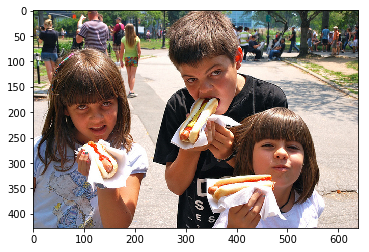

In [97]:
img = plt.imread(PATH/'hotdogs_train/hotdog'/files[1])
plt.imshow(img)

Here is how the raw data looks like

In [18]:
img.shape

(480, 640, 3)

In [100]:
img[:4,:4, 2]

array([[59, 63, 60, 49],
       [53, 68, 71, 70],
       [60, 70, 79, 82],
       [66, 72, 82, 83]], dtype=uint8)

## Our first model: quick start

In [55]:
sz=256

In [101]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), 
                                      trn_name='hotdogs_train', val_name='hotdogs_valid', 
                                      num_workers=8)
learn = ConvLearner.pretrained(arch, data)

In [102]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.233181   0.152298   0.929412  
    1      0.187359   0.148608   0.921569  


[array([0.14861]), 0.9215686281522115]

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [25]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [104]:
data.classes

['hotdog', 'nothotdog']

In [105]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()

In [27]:
log_preds.shape

(255, 2)

In [28]:
log_preds[:10]

array([[-0.0798 , -2.56786],
       [-0.00324, -5.73486],
       [-0.03491, -3.37229],
       [-0.78209, -0.61147],
       [-0.00511, -5.27856],
       [-0.44955, -1.01587],
       [-0.13423, -2.07459],
       [-0.81751, -0.58256],
       [-0.0481 , -3.05846],
       [-0.03111, -3.4856 ]], dtype=float32)

In [106]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(not_hotdog)

In [107]:
probs[:5]

array([0.20416, 0.01966, 0.15681, 0.4083 , 0.00852], dtype=float32)

In [108]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return open_image(PATH/ds.fnames[idx])# np.array(PIL.Image.open())

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


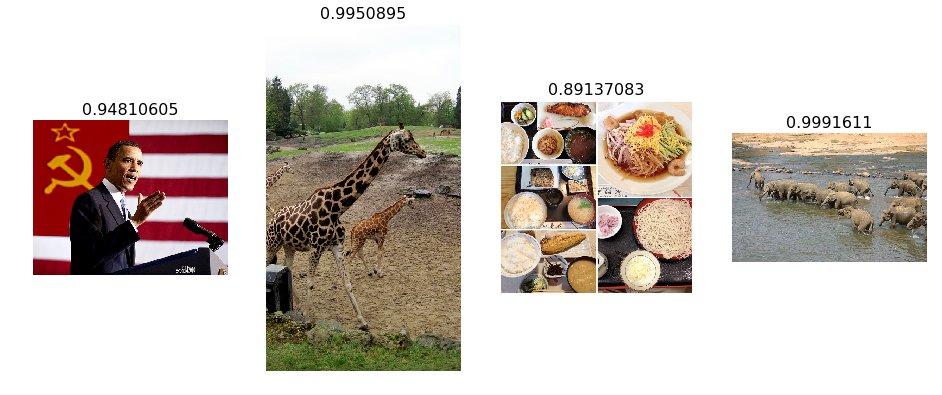

In [109]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


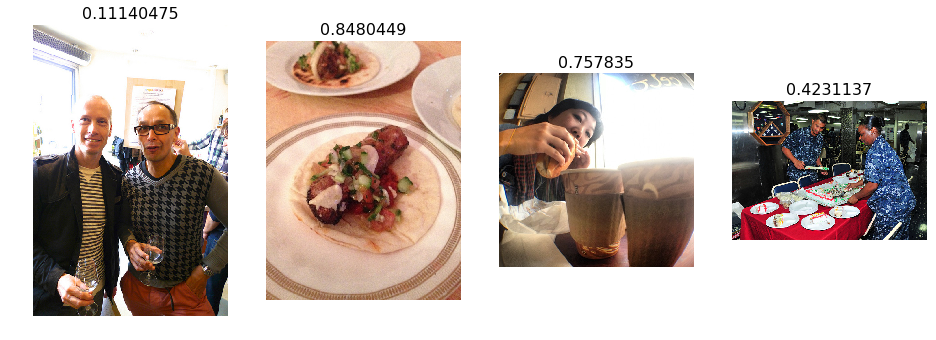

In [110]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct hotdogs


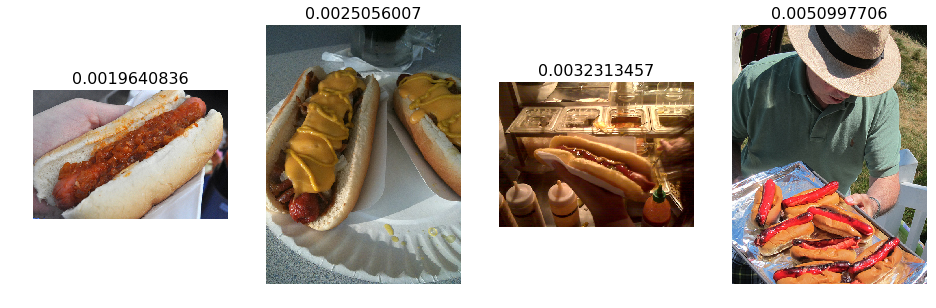

In [34]:
plot_val_with_title(most_by_correct(0, True), "Most correct hotdogs")

Most correct not hotdogs


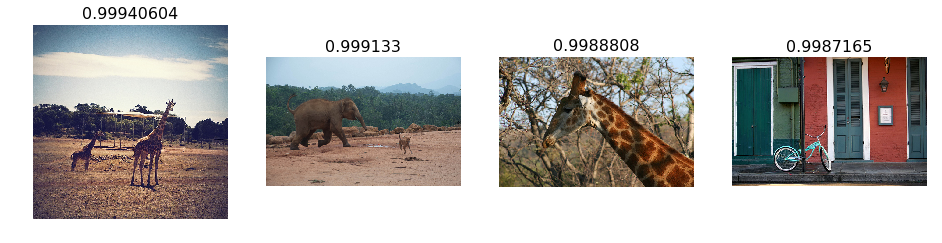

In [35]:
plot_val_with_title(most_by_correct(1, True), "Most correct not hotdogs")

Most incorrect hotdogs


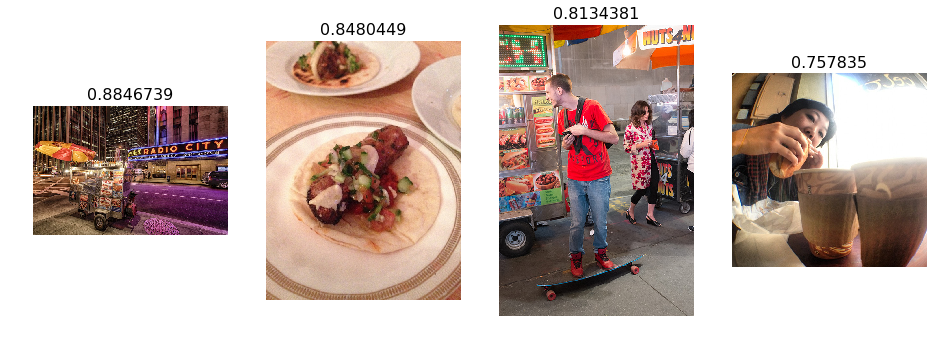

In [111]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect hotdogs")

Most incorrect nothotdogs


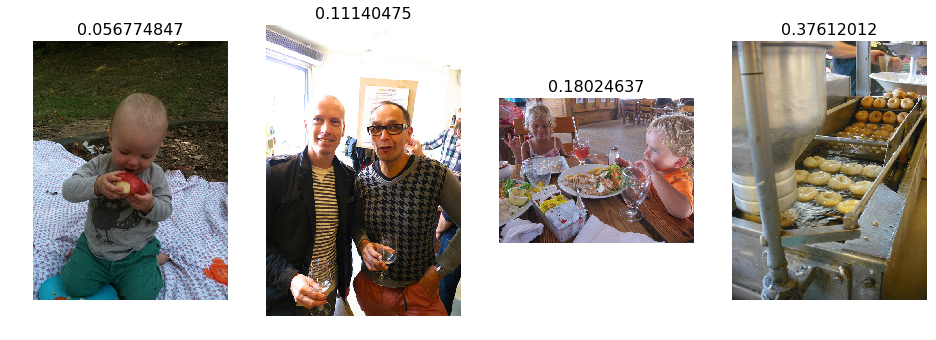

In [112]:

plot_val_with_title(most_by_correct(1, False), "Most incorrect nothotdogs")

Most uncertain predictions


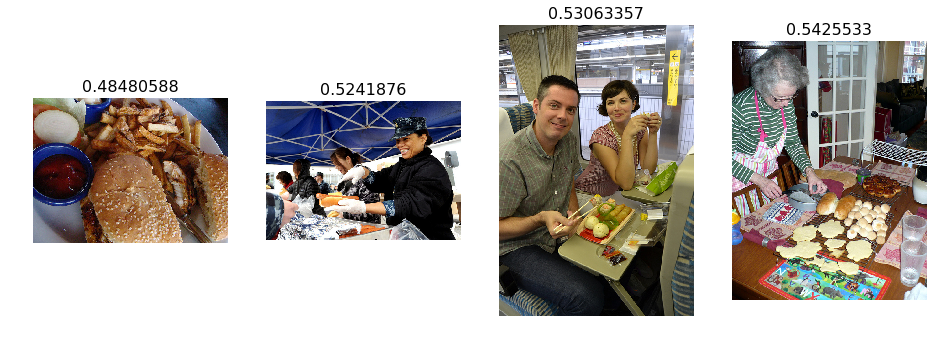

In [38]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Improving our model

## Choosing a learning rate

### Data augmentation

In [58]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [114]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1, 
                                          trn_name='hotdogs_train',
                                         val_name='hotdogs_valid')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [115]:
ims = np.stack([get_augs() for i in range(6)])

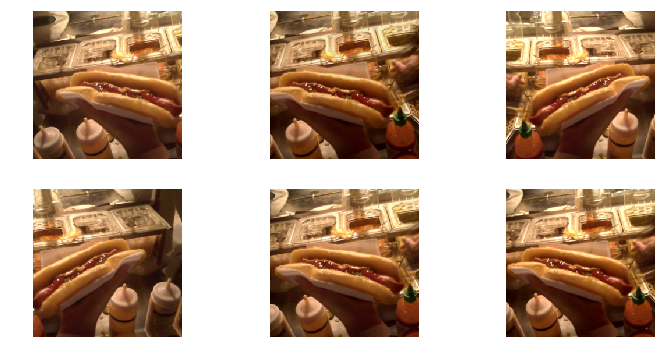

In [116]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [117]:
arch=resnet50
sz=256
bs=64
nw=8

In [118]:
data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=nw,
                                      trn_name='hotdogs_train', val_name='hotdogs_valid')
learn = ConvLearner.pretrained(arch, data)

 93%|█████████▎| 89/96 [01:46<00:08,  1.20s/it, loss=1.86]

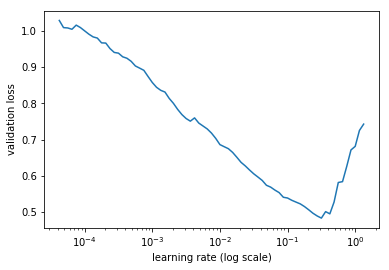

In [74]:
lrf=learn.lr_find()
learn.sched.plot()

In [119]:
lr=1e-1

In [120]:
learn.fit(lr, 1, cycle_len=6, use_clr=(10, 10))

epoch      trn_loss   val_loss   accuracy   
    0      0.313769   0.241579   0.933333  
    1      0.243757   0.188838   0.92549   
    2      0.184481   0.106446   0.952941  
    3      0.141635   0.108754   0.956863  
    4      0.125388   0.116849   0.94902   
    5      0.105882   0.097021   0.952941  


[array([0.09702]), 0.9529411764705882]

In [121]:
learn.save(f'hotdog_last_{sz}')

In [47]:
learn.load(f'hotdog_last_{sz}')

### Fine-tuning and differential learning rate annealing

In [68]:
learn.unfreeze()

 79%|███████▉  | 76/96 [01:16<00:20,  1.01s/it, loss=0.516]

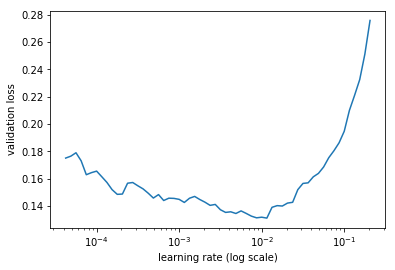

In [69]:
lrf=learn.lr_find()
learn.sched.plot()

In [70]:
lr=1e-3
lrs = np.array([lr/100,lr/10,lr])

In [71]:
learn.fit(lrs, 1, cycle_len=8, use_clr=(5,8))

epoch      trn_loss   val_loss   accuracy   
    0      0.145057   0.140183   0.921569  
    1      0.148892   0.140913   0.913725  
    2      0.134404   0.141002   0.913725  
    3      0.132474   0.140444   0.913725  
  3%|▎         | 3/96 [00:07<04:03,  2.61s/it, loss=0.133]

KeyboardInterrupt: 

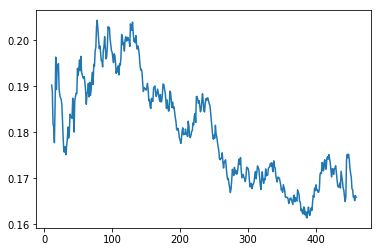

In [65]:
learn.sched.plot_loss()

In [70]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.185389   0.141486   0.934641  
    1      0.180215   0.135738   0.947712  
    2      0.16447    0.143564   0.941176  
    3      0.167836   0.134384   0.947712  
    4      0.158106   0.137694   0.941176  
    5      0.156433   0.1444     0.921569  
    6      0.151381   0.130342   0.954248  


[array([0.13034]), 0.9542483687400818]

In [71]:
learn.save(f'hotdog_all_{sz}')

In [9]:
learn.load(f'hotdog_all_{sz}')

In [48]:
torch.save(learn.model, PATH/'deploy_models/hotdog.h5')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [64]:
log_preds,y = learn.TTA(n_aug=8)
probs = np.mean(np.exp(log_preds),0)

In [65]:
accuracy_np(probs, y)

0.9490196078431372

In [66]:
log_preds = learn.predict()
probs = np.exp(log_preds)  

In [63]:
accuracy_np(probs, y)

0.9568627450980393

## Analyzing results

### Confusion matrix 

In [67]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 44   7]
 [  4 200]]


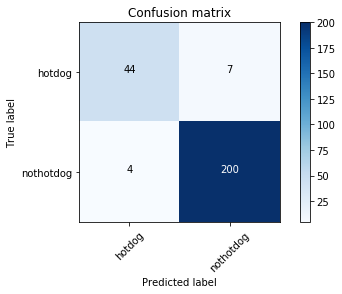

In [69]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect hotdogs


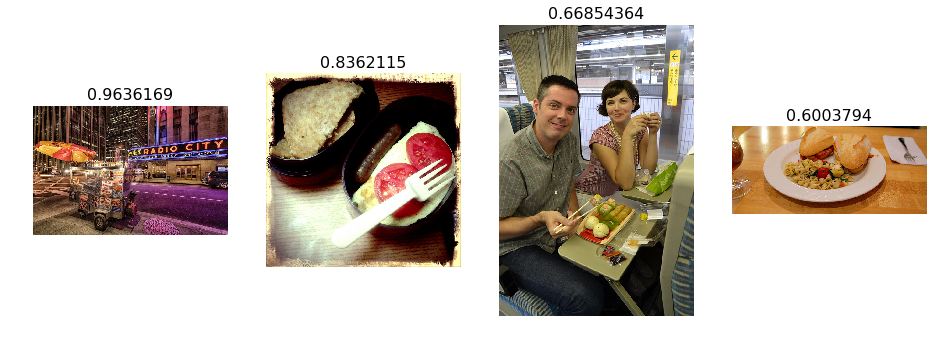

In [70]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect hotdogs")

Most incorrect nothotdogs


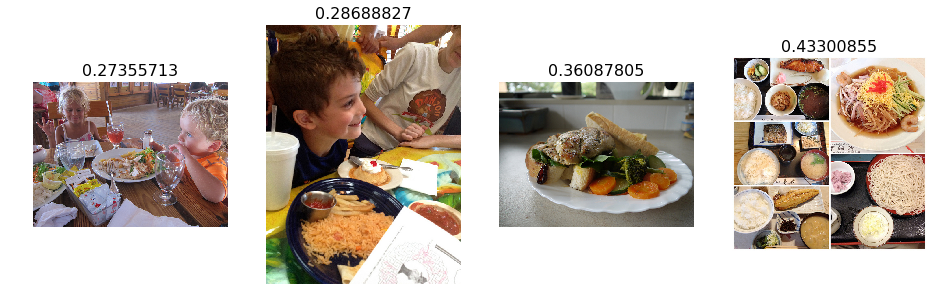

In [71]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect nothotdogs")